# Learn a Reward Function using Maximum Conditional Entropy Inverse Reinforcement Learning

MCE IRL only supports tabular environments.

The cliffworld environment, that we use here is a TabularEnvironment.
It's observations consist of the POMDP's observations and the actual state.
We later also need VecEnv objects that expose just the internal POMDP-state or just the POMDP-observation as its observation.

In [1]:
from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)
import gym
from imitation.algorithms import base

from imitation.data import rollout
from imitation.envs import resettable_env
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.rewards import reward_nets
from imitation.rewards.reward_wrapper import RewardVecEnvWrapper
from imitation.envs.examples.model_envs import CliffWorld


env_name = "imitation/Explore-v0"

env : CliffWorld = gym.make(env_name)
state_venv = resettable_env.DictExtractWrapper(
    DummyVecEnv([lambda: gym.make(env_name)] * 4), "state"
)
obs_venv = resettable_env.DictExtractWrapper(
    DummyVecEnv([lambda: gym.make(env_name)] * 4), "obs"
)
print(env)

<OrderEnforcing
G______
_______
####_##
_______
S______
>


Then we derive an expert policy using Bellman backups. We analytically compute the occupancy measures, and also sample some expert trajectories.

In [2]:
_, _, pi = mce_partition_fh(env)

_, om = mce_occupancy_measures(env, pi=pi)

expert = TabularPolicy(
    state_space=env.pomdp_state_space,
    action_space=env.action_space,
    pi=pi,
    rng=None,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

Expert stats:  {'n_traj': 500, 'return_min': 12.0, 'return_mean': 12.0, 'return_std': 0.0, 'return_max': 12.0, 'len_min': 10, 'len_mean': 10.0, 'len_std': 0.0, 'len_max': 10}


Finally, we set up the MCE algorithm and train it.

In [3]:
def train_mce_irl(demos, **kwargs):
    reward_net = reward_nets.BasicRewardNet(
        env.pomdp_observation_space,
        env.action_space,
        use_action=False,
        use_next_state=False,
        use_done=False,
        hid_sizes=[],
    )

    mce_irl = MCEIRL(demos, env, reward_net, linf_eps=1e-3)
    mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    return mce_irl

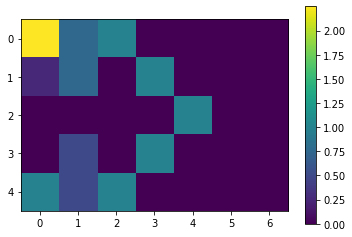

In [4]:
env.draw_value_vec(om)

First, we train it on the analytically computed occupancy measures. This should give a very precise result.

In [5]:
mce_irl_from_om = train_mce_irl(om)

--------------------------
| grad_norm   | 4.53     |
| iteration   | 0        |
| linf_delta  | 2.38     |
| weight_norm | 0.587    |
--------------------------
--------------------------
| grad_norm   | 2.1      |
| iteration   | 100      |
| linf_delta  | 1.91     |
| weight_norm | 4.78     |
--------------------------
--------------------------
| grad_norm   | 1.32     |
| iteration   | 200      |
| linf_delta  | 1.27     |
| weight_norm | 6.87     |
--------------------------
--------------------------
| grad_norm   | 0.788    |
| iteration   | 300      |
| linf_delta  | 0.761    |
| weight_norm | 8.2      |
--------------------------
--------------------------
| grad_norm   | 0.49     |
| iteration   | 400      |
| linf_delta  | 0.472    |
| weight_norm | 9.13     |
--------------------------
--------------------------
| grad_norm   | 0.328    |
| iteration   | 500      |
| linf_delta  | 0.315    |
| weight_norm | 9.79     |
--------------------------
--------------------------
|

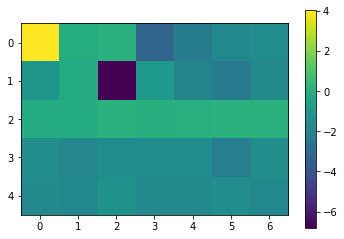

In [6]:
r_pred_from_om = mce_irl_from_om.get_predicted_r()
env.draw_value_vec(r_pred_from_om)

Then we train it on trajectories sampled from the expert. This gives a stochastic approximation to occupancy measure, so performance is a little worse. Using more expert trajectories should improve performance -- try it!

In [7]:
mce_irl_from_trajs = train_mce_irl(expert_trajs[0:10])

--------------------------
| grad_norm   | 5.1      |
| iteration   | 0        |
| linf_delta  | 3        |
| weight_norm | 0.577    |
--------------------------
--------------------------
| grad_norm   | 2.9      |
| iteration   | 100      |
| linf_delta  | 2.71     |
| weight_norm | 5.27     |
--------------------------
--------------------------
| grad_norm   | 2        |
| iteration   | 200      |
| linf_delta  | 1.93     |
| weight_norm | 8.28     |
--------------------------
--------------------------
| grad_norm   | 1.39     |
| iteration   | 300      |
| linf_delta  | 1.31     |
| weight_norm | 10.4     |
--------------------------
--------------------------
| grad_norm   | 1.1      |
| iteration   | 400      |
| linf_delta  | 1.02     |
| weight_norm | 12       |
--------------------------
--------------------------
| grad_norm   | 0.992    |
| iteration   | 500      |
| linf_delta  | 0.902    |
| weight_norm | 13.4     |
--------------------------
--------------------------
|

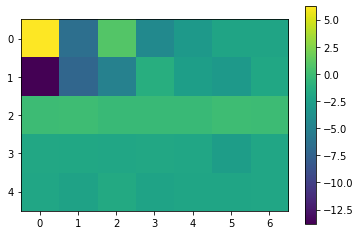

In [8]:
r_pred_from_trajs = mce_irl_from_trajs.get_predicted_r()
env.draw_value_vec(r_pred_from_trajs)

In [12]:
test_env_name = "imitation/ExploreCloseGap-v0"
test_env = gym.make(test_env_name)
test_venv = resettable_env.DictExtractWrapper(
    RewardVecEnvWrapper(DummyVecEnv([lambda: gym.make(test_env_name)] * 4),
     mce_irl_from_om.reward_net), "state"
)
print(test_env) #TODO(lev) complete implementation of transfer here.  
_, _, pi_learner = mce_partition_fh(test_env)

_, om_learner = mce_occupancy_measures(test_env, pi=pi_learner)

learner = TabularPolicy(
    state_space=test_env.pomdp_state_space,
    action_space=test_env.action_space,
    pi=pi_learner,
    rng=None,
)

learner_trajs = rollout.generate_trajectories(
    policy=learner,
    venv=test_venv,
    sample_until=rollout.make_min_timesteps(5000),
)

print("Learner stats: ", rollout.rollout_stats(expert_trajs))


<OrderEnforcing
G______
_______
_######
_______
S______
>


TypeError: flatten(): argument 'input' (position 1) must be Tensor, not collections.OrderedDict

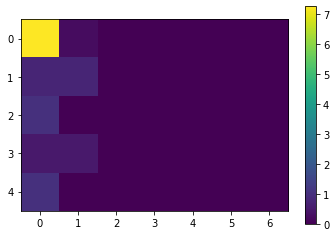

In [13]:
env.draw_value_vec(om_learner)